# Assignment 1.4: Negative sampling (15 points)

You may have noticed that word2vec is really slow to train. Especially with big (> 50 000) vocabularies. Negative sampling is the solution.

The task is to implement word2vec with negative sampling.

This is what was discussed in Stanford lecture. The main idea is in the formula:

$$ L = \log\sigma(u^T_o \cdot u_c) + \sum^k_{i=1} \mathbb{E}_{j \sim P(w)}[\log\sigma(-u^T_j \cdot u_c)]$$

Where $\sigma$ - sigmoid function, $u_c$ - central word vector, $u_o$ - context (outside of the window) word vector, $u_j$ - vector or word with index $j$.

The first term calculates the similarity between positive examples (word from one window)

The second term is responsible for negative samples. $k$ is a hyperparameter - the number of negatives to sample.
$\mathbb{E}_{j \sim P(w)}$
means that $j$ is distributed accordingly to unigram distribution.

Thus, it is only required to calculate the similarity between positive samples and some other negatives. Not across all the vocabulary.

Useful links:
1. [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781.pdf)
1. [Distributed Representations of Words and Phrases and their Compositionality](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)

In [96]:
import gc
import string
import re
from collections import Counter
import numpy as np
gc.collect()
import nltk
from nltk.corpus import stopwords
STOP_WORDS = set(stopwords.words('english'))
len(STOP_WORDS)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.manual_seed(1)
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
import numpy as np
from numpy.random import choice
import seaborn as sns

USE_GPU = True
dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print (torch.cuda.get_device_name(0))

GeForce GTX 1050 Ti


_______________________________

### Create own batcher with batch generator

In [97]:
class Batcher:
    def __init__(self, max_len, window_size, corpus_path, min_freq, max_freq, max_voc_size, batch_size):
        self.corpus_path = corpus_path
        self.window_size = window_size
        self.min_freq = min_freq
        self.max_freq = max_freq
        self.max_voc_size = max_voc_size
        self.batch_size = batch_size
        self.max_len = max_len
        self.words = None
        self.word2index = None
        self.index2word = None
        self.freq = None
        self.voc = None
        self.voc_size = None
        self.corpus = None
        self.corpus_size = None  
        
    def read_data(self, S):
        if S == None:
            with open(self.corpus_path, 'r') as f:
                S = f.read()
            if S!=None:
                S = S.lower()[: self.max_len]
        print('Len of S = ', len(S))
        regex = re.compile('[%s]' % re.escape(string.punctuation))
        S = regex.sub(' ', S)
        words_raw = list(S.split())
        print(len(words_raw))
        words = []
        for word in words_raw:
            if word in STOP_WORDS:
                pass
            else:
                words.append(word)

        print('Size of words = ', len(words))
        counter = Counter(words)
        print('Size of counter = ', len(counter))
        if self.min_freq != None:
            counter = {x : counter[x] for x in counter if counter[x] >= self.min_freq}
        print('Size of counter after min_freq = ', len(counter))
        if self.max_freq != None:
            counter = {x : counter[x] for x in counter if counter[x] <= self.max_freq}
        print('Size of counter after max_freq = ', len(counter))
        counter = Counter(counter)

        freq = dict(counter.most_common(self.max_voc_size))
        voc = set(freq)
        
        unk = set(words).difference(voc)
        print('Size of freq dict = ', len(voc))
        print('Number of vocabulary words = ', len(voc))
        print('Number of unknown words = ', len(unk))

        words = ['UNK' if word in unk else word for word in words]        
        if len(words)%self.batch_size == 0:
            padding = self.window_size
        else:
            padding = self.batch_size - len(words)%self.batch_size + self.window_size
            
        words = ['PAD']*self.window_size + words + ['PAD']*padding
        unique_words = list(set(words))
        print('Size of corpus = ', len(words))
        print('Size of vocabulary = ', len(unique_words))
        self.word2index = {k: v for v, k in enumerate(unique_words)}
        self.index2word = {v: k for v, k in enumerate(unique_words)}
        words = [self.word2index[word] for word in words]
        self.freq = Counter(words)
        self.voc = set(self.freq)
        self.voc_size = len(self.voc)
        self.corpus = words
        self.corpus_size = len(words)
    
    def generator(self):
        i = self.window_size
        x_batch = []
        y_batch = []
        
        while i < self.corpus_size-self.window_size:
            if len(x_batch)==self.batch_size:
                x_batch = []
                y_batch = []
                
            x = self.corpus[i-self.window_size: i] + self.corpus[i+1: i+self.window_size+1]
            y = [self.corpus[i]]*self.window_size*2
            x_batch.append(x)
            y_batch.append(y)
            i += 1
            if len(x_batch)==self.batch_size:
                yield np.array(x_batch), np.array(y_batch)

### Initialize Batcher with parameters

In [98]:
BATCH_SIZE = 8192
MAX_LEN = 100000000000
batcher = Batcher(max_len=MAX_LEN, window_size=2, corpus_path='text8', min_freq=5, max_freq=None, max_voc_size=10000000, batch_size=BATCH_SIZE)
batcher.read_data(S=None)

Len of S =  100000000
17005207
Size of words =  10890638
Size of counter =  253702
Size of counter after min_freq =  71140
Size of counter after max_freq =  71140
Size of freq dict =  71140
Number of vocabulary words =  71140
Number of unknown words =  182562
Size of corpus =  10895364
Size of vocabulary =  71142


### Check dimentions

In [99]:
for x, y in batcher.generator():
    print(x.shape, y.shape)
    break

(8192, 4) (8192, 4)


### Check value of the first batch

In [1]:
for x, y in batcher.generator():
    for i in range(x.shape[0]):
        target_word = y[i][0]
        for j in range(x.shape[1]):
            context_word = x[i][j]
            print(batcher.index2word[target_word], batcher.index2word[context_word])
    break

### Create CBOW with naive Negative Sampling class using PyTorch

In [101]:
class CBOW(nn.Module):
    def __init__(self, voc_size, embedding_dim, window_size, batch_size):
        super(CBOW, self).__init__()
        self.embedding1 = nn.Embedding(voc_size, embedding_dim)
        self.embedding2 = nn.Embedding(voc_size, embedding_dim)
        
    def forward(self, target_word, context_word):
        target_word = torch.tensor(target_word).to(device='cuda')
        context_word = torch.tensor(context_word).to(device='cuda')
        target_emb = self.embedding1(target_word)
        context_emb = self.embedding2(context_word)
        z1 = torch.mul(target_emb, context_emb)
        z2 = torch.sum(z1, dim=2)
        pos_loss = torch.sum(F.logsigmoid(z2))

        neg_loss = 0
        for i in range(5):
            negative_word = choice(batcher.corpus, size=batcher.batch_size*batcher.window_size*2).reshape((batcher.batch_size, batcher.window_size*2))
            negative_word = torch.tensor(numpy.random.choice(batcher.corpus)).to(device='cuda')
            negative_emb = self.embedding2(negative_word)
            z4 = torch.mul(target_emb, negative_emb)
            z5 = torch.sum(z4, dim=2)
            z6 = torch.sum(F.logsigmoid(-z5))
            neg_loss += z6
        
        return -(pos_loss + neg_loss)

### Run training with Negative Sampling and Exponential Scheduler

In [81]:
losses = []
model = CBOW(voc_size=batcher.voc_size, embedding_dim=256, window_size=batcher.window_size, batch_size=batcher.batch_size)
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.01)
lr_scheduler = ReduceLROnPlateau(optimizer = optimizer, \
                                 mode = 'min', \
                                 factor = 0.5, \
                                 threshold = 0.001 \
                                )

for epoch in range(10):
    print('========== Epoch {} =========='.format(epoch))
    total_loss = 0
    i = 0
    N = int(len(batcher.corpus)//BATCH_SIZE)
    for context, target in batcher.generator():
        model.train()

        loss = model(target, context)

        optimizer.zero_grad()
        model.zero_grad()
        loss.backward()
        optimizer.step()

        print('Batch {}/{} loss : {}'.format(i, N, loss/(BATCH_SIZE*batcher.window_size*2)), '\n')
        losses.append(loss)
        i += 1

========== Epoch 0 ==========
Batch 0/134 loss : 42.06694030761719 

Batch 1/134 loss : 41.704933166503906 

Batch 2/134 loss : 39.430267333984375 

Batch 3/134 loss : 38.71807861328125 

Batch 4/134 loss : 39.73075866699219 

Batch 5/134 loss : 40.66918182373047 

Batch 6/134 loss : 38.6294059753418 

Batch 7/134 loss : 40.35169982910156 

Batch 8/134 loss : 38.260215759277344 

Batch 9/134 loss : 39.16942596435547 

Batch 10/134 loss : 38.10734558105469 

Batch 11/134 loss : 35.58789825439453 

Batch 12/134 loss : 34.93800354003906 

Batch 13/134 loss : 35.9769172668457 

Batch 14/134 loss : 35.67118453979492 

Batch 15/134 loss : 35.47370529174805 

Batch 16/134 loss : 37.17887878417969 

Batch 17/134 loss : 35.50787353515625 

Batch 18/134 loss : 35.08230972290039 

Batch 19/134 loss : 33.56196212768555 

Batch 20/134 loss : 38.42351150512695 

Batch 21/134 loss : 37.90135955810547 

Batch 22/134 loss : 41.83424377441406 

Batch 23/134 loss : 39.043792724609375 

Batch 24/134 loss 

Batch 67/134 loss : 27.82274627685547 

Batch 68/134 loss : 24.64341163635254 

Batch 69/134 loss : 15.150001525878906 

Batch 70/134 loss : 24.52313232421875 

Batch 71/134 loss : 15.214583396911621 

Batch 72/134 loss : 16.40041732788086 

Batch 73/134 loss : 21.042037963867188 

Batch 74/134 loss : 23.99235725402832 

Batch 75/134 loss : 22.24390411376953 

Batch 76/134 loss : 29.38700294494629 

Batch 77/134 loss : 30.703094482421875 

Batch 78/134 loss : 25.650856018066406 

Batch 79/134 loss : 27.229095458984375 

Batch 80/134 loss : 25.245319366455078 

Batch 81/134 loss : 29.829444885253906 

Batch 82/134 loss : 29.383737564086914 

Batch 83/134 loss : 25.412403106689453 

Batch 84/134 loss : 13.308046340942383 

Batch 85/134 loss : 21.357872009277344 

Batch 86/134 loss : 19.464984893798828 

Batch 87/134 loss : 23.710956573486328 

Batch 88/134 loss : 28.732437133789062 

Batch 89/134 loss : 15.417354583740234 

Batch 90/134 loss : 20.17707061767578 

Batch 91/134 loss : 16.9

Batch 133/134 loss : 8.49421215057373 

========== Epoch 3 ==========
Batch 0/134 loss : 16.45189094543457 

Batch 1/134 loss : 14.671704292297363 

Batch 2/134 loss : 18.693368911743164 

Batch 3/134 loss : 24.414857864379883 

Batch 4/134 loss : 20.07969856262207 

Batch 5/134 loss : 17.818195343017578 

Batch 6/134 loss : 24.972721099853516 

Batch 7/134 loss : 23.24526023864746 

Batch 8/134 loss : 24.157817840576172 

Batch 9/134 loss : 22.384754180908203 

Batch 10/134 loss : 13.957990646362305 

Batch 11/134 loss : 15.059709548950195 

Batch 12/134 loss : 20.675907135009766 

Batch 13/134 loss : 19.33056640625 

Batch 14/134 loss : 23.417299270629883 

Batch 15/134 loss : 17.35731315612793 

Batch 16/134 loss : 18.26557159423828 

Batch 17/134 loss : 18.106096267700195 

Batch 18/134 loss : 14.742610931396484 

Batch 19/134 loss : 12.089473724365234 

Batch 20/134 loss : 18.889217376708984 

Batch 21/134 loss : 19.078227996826172 

Batch 22/134 loss : 15.531713485717773 

Batch 

Batch 66/134 loss : 16.260038375854492 

Batch 67/134 loss : 16.27086067199707 

Batch 68/134 loss : 17.829591751098633 

Batch 69/134 loss : 18.26114845275879 

Batch 70/134 loss : 15.348941802978516 

Batch 71/134 loss : 14.364439010620117 

Batch 72/134 loss : 13.881126403808594 

Batch 73/134 loss : 19.628761291503906 

Batch 74/134 loss : 20.511966705322266 

Batch 75/134 loss : 18.758636474609375 

Batch 76/134 loss : 17.48552703857422 

Batch 77/134 loss : 13.222464561462402 

Batch 78/134 loss : 20.886417388916016 

Batch 79/134 loss : 14.93856143951416 

Batch 80/134 loss : 12.074054718017578 

Batch 81/134 loss : 12.079110145568848 

Batch 82/134 loss : 12.345052719116211 

Batch 83/134 loss : 12.26734447479248 

Batch 84/134 loss : 18.205812454223633 

Batch 85/134 loss : 15.108814239501953 

Batch 86/134 loss : 11.76219367980957 

Batch 87/134 loss : 10.594650268554688 

Batch 88/134 loss : 17.10917091369629 

Batch 89/134 loss : 16.884273529052734 

Batch 90/134 loss : 17.

Batch 132/134 loss : 15.052877426147461 

Batch 133/134 loss : 48.1066780090332 

========== Epoch 6 ==========
Batch 0/134 loss : 21.517038345336914 

Batch 1/134 loss : 17.292255401611328 

Batch 2/134 loss : 10.30292797088623 

Batch 3/134 loss : 19.324617385864258 

Batch 4/134 loss : 17.816118240356445 

Batch 5/134 loss : 14.459976196289062 

Batch 6/134 loss : 12.628499984741211 

Batch 7/134 loss : 11.434514999389648 

Batch 8/134 loss : 16.604598999023438 

Batch 9/134 loss : 14.61286735534668 

Batch 10/134 loss : 12.126258850097656 

Batch 11/134 loss : 12.385948181152344 

Batch 12/134 loss : 11.945281028747559 

Batch 13/134 loss : 11.886029243469238 

Batch 14/134 loss : 13.66872787475586 

Batch 15/134 loss : 15.994502067565918 

Batch 16/134 loss : 20.885480880737305 

Batch 17/134 loss : 16.431148529052734 

Batch 18/134 loss : 20.35764503479004 

Batch 19/134 loss : 15.863480567932129 

Batch 20/134 loss : 13.84191608428955 

Batch 21/134 loss : 14.525917053222656 

B

Batch 64/134 loss : 12.267443656921387 

Batch 65/134 loss : 18.767047882080078 

Batch 66/134 loss : 13.422926902770996 

Batch 67/134 loss : 9.657476425170898 

Batch 68/134 loss : 12.64712142944336 

Batch 69/134 loss : 14.786314010620117 

Batch 70/134 loss : 10.208247184753418 

Batch 71/134 loss : 18.40610122680664 

Batch 72/134 loss : 10.694995880126953 

Batch 73/134 loss : 14.494327545166016 

Batch 74/134 loss : 12.518089294433594 

Batch 75/134 loss : 22.81504249572754 

Batch 76/134 loss : 15.536825180053711 

Batch 77/134 loss : 14.656982421875 

Batch 78/134 loss : 16.605697631835938 

Batch 79/134 loss : 9.693449020385742 

Batch 80/134 loss : 5.513893127441406 

Batch 81/134 loss : 14.603771209716797 

Batch 82/134 loss : 13.33333683013916 

Batch 83/134 loss : 21.19378662109375 

Batch 84/134 loss : 8.989269256591797 

Batch 85/134 loss : 20.69537353515625 

Batch 86/134 loss : 12.951547622680664 

Batch 87/134 loss : 15.611388206481934 

Batch 88/134 loss : 17.050712

Batch 130/134 loss : 9.577512741088867 

Batch 131/134 loss : 12.986888885498047 

Batch 132/134 loss : 12.687746047973633 

Batch 133/134 loss : 8.167486190795898 

========== Epoch 9 ==========
Batch 0/134 loss : 13.42275619506836 

Batch 1/134 loss : 13.505138397216797 

Batch 2/134 loss : 9.52198600769043 

Batch 3/134 loss : 17.19765853881836 

Batch 4/134 loss : 11.031309127807617 

Batch 5/134 loss : 10.294811248779297 

Batch 6/134 loss : 13.848130226135254 

Batch 7/134 loss : 11.39900016784668 

Batch 8/134 loss : 13.221242904663086 

Batch 9/134 loss : 18.64715576171875 

Batch 10/134 loss : 5.751086711883545 

Batch 11/134 loss : 14.953400611877441 

Batch 12/134 loss : 9.111774444580078 

Batch 13/134 loss : 19.002716064453125 

Batch 14/134 loss : 13.544921875 

Batch 15/134 loss : 7.409868240356445 

Batch 16/134 loss : 16.244110107421875 

Batch 17/134 loss : 21.64085578918457 

Batch 18/134 loss : 8.107471466064453 

Batch 19/134 loss : 12.541084289550781 

Batch 20/13

[Text(0, 0.5, 'Loss'), Text(0.5, 0, 'Batch')]

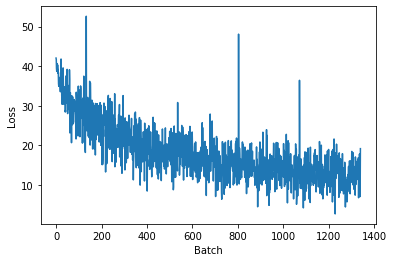

In [95]:
losses2plot = []
batches2plot = []
for i in range(len(losses)):
    losses2plot.append(float(losses[i])/(BATCH_SIZE*batcher.window_size*2))
    batches2plot.append(i)
sns.lineplot(batches2plot, losses2plot).set(xlabel='Batch', ylabel='Loss')